# Prepare notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data

In [3]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
profession_filter = re.compile(r'(?<=is a)(.*?)(?=\.)')

In [6]:
books['author_profession'] = books.goodreads_author_bio.fillna('').apply(lambda s: re.search(profession_filter, s).group(1) 
                                                                         if re.search(profession_filter, s) is not None else None)

In [7]:
books.author_profession.count()

227

# Prepare textual data

In [8]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_author_profession'] = books.author_profession.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                 if token not in stop_words
                                                               ]))

<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-8-4aad89f809f0>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [9]:
books['filtered_doc_length'] = books.filtered_author_profession.map(lambda text: len(text.split(' ')))

 # Visualization

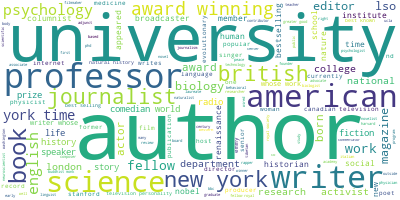

In [35]:
# Generate a word cloud based on all author_bios
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_author_profession.drop_duplicates().values)))
wordcloud.to_image()

# Word counting methods

In [12]:
max_df=0.90
min_df=4
max_features=2000


### Bag of words

In [36]:
# Fit and transform the author_bios
word_bag_cv = CountVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
word_bag_counts = word_bag_cv.fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['american', 'professor', 'writer', 'university', 'author']

### Bag of bigrams

In [37]:
# Fit and transform the author_bios
bigram_bag_cv = CountVectorizer(ngram_range=(2,2), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
bigram_bag_counts = bigram_bag_cv .fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['natural history',
 'professor psychology',
 'york time',
 'new york',
 'award winning']

### TF-IDF 

In [41]:
tfidf_v = TfidfVectorizer(use_idf=True, max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english' )
tfidf_weights = tfidf_v.fit_transform(books.filtered_author_profession.drop_duplicates())

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['journalist',
 'new',
 'university',
 'award',
 'author',
 'science',
 'professor',
 'writer',
 'american',
 'british']

# Profession Modeling

In [42]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [43]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 5

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [44]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: professor university psychology biology department science research fellow stanford history
 Topic #1: author british speaker work english activist poet buddhist radio bestselling
 Topic #2: writer british journalist english historian actor born broadcaster lso winning
 Topic #3: new time york book award science winning magazine appeared publication
 Topic #4: american journalist nobel radio known science record host best prize



In [45]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: professor university fellow history psychology biology nd department human college
 Topic #1: author english born work speaker fiction popular british internet poet
 Topic #2: writer british journalist lso award winning historian world nature story
 Topic #3: new book science time york national woman magazine editor appeared
 Topic #4: american television actor award known prize nobel personality life activist



In [46]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: author american journalist best science book nobel award canadian world
 Topic #1: writer journalist british historian winning author award fellow speaker london
 Topic #2: new time york author book editor writer magazine work award
 Topic #3: english actor writer comedian author human story poet activist popular
 Topic #4: university professor science biology psychology department history college fellow london



In [47]:


lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.drop_duplicates(subset =['filtered_author_profession']).filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [48]:
from sklearn.metrics import log_loss, make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [49]:
def custom_scorer_highest_topic_silhouette(estimator, X):
    X = X.toarray()
    return silhouette_score(X, np.argmax(estimator.transform(X), axis =1))
  
def custom_scorer_highest_topic_calinski_harabasz(estimator, X):
    X = X.toarray()
    return calinski_harabasz_score(X, np.argmax(estimator.transform(X), axis =1))


def custom_scorer_kmeans_silhouette(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return silhouette_score(X, labels)
  
def custom_scorer_kmeans_calinski_harabasz(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return calinski_harabasz_score(X, labels)

def custom_scorer_log_likelihood(estimator, X):
    X = X.toarray()
    return estimator.score(X)

def custom_scorer_negative_perplexity(estimator, X):
    X = X.toarray()
    return -1*estimator.perplexity(X)

In [55]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           'log_likelihood': custom_scorer_log_likelihood,
           'negative_perplexity': custom_scorer_negative_perplexity}

param_grid={'n_components': [2, 4, 6], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [20, 30, 40], 
                                    'max_iter': [50, 75, 100]}

In [50]:
# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'log_likelihood',
                        cv=3, n_jobs = -1, verbose = 2)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.7min finished
/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
import pickle
pickle.dump(model_lda, open('gridsearchcv_lda_customScoring_author_professions.pkl', 'wb'))

In [52]:
lda_data =  pyLDAvis.prepare(topic_term_dists = model_lda.best_estimator_.components_, 
                             doc_topic_dists = model_lda.best_estimator_.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.drop_duplicates(subset= 'filtered_author_profession').filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [53]:
print("\nTopics in LDA model:")
print_top_words(model_lda.best_estimator_, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: author writer american award journalist british winning book english history
 Topic #1: university professor science new time york fellow psychology biology magazine



In [57]:
results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_lda.cv_results_['param_'+param].data, columns = [param]))
#results

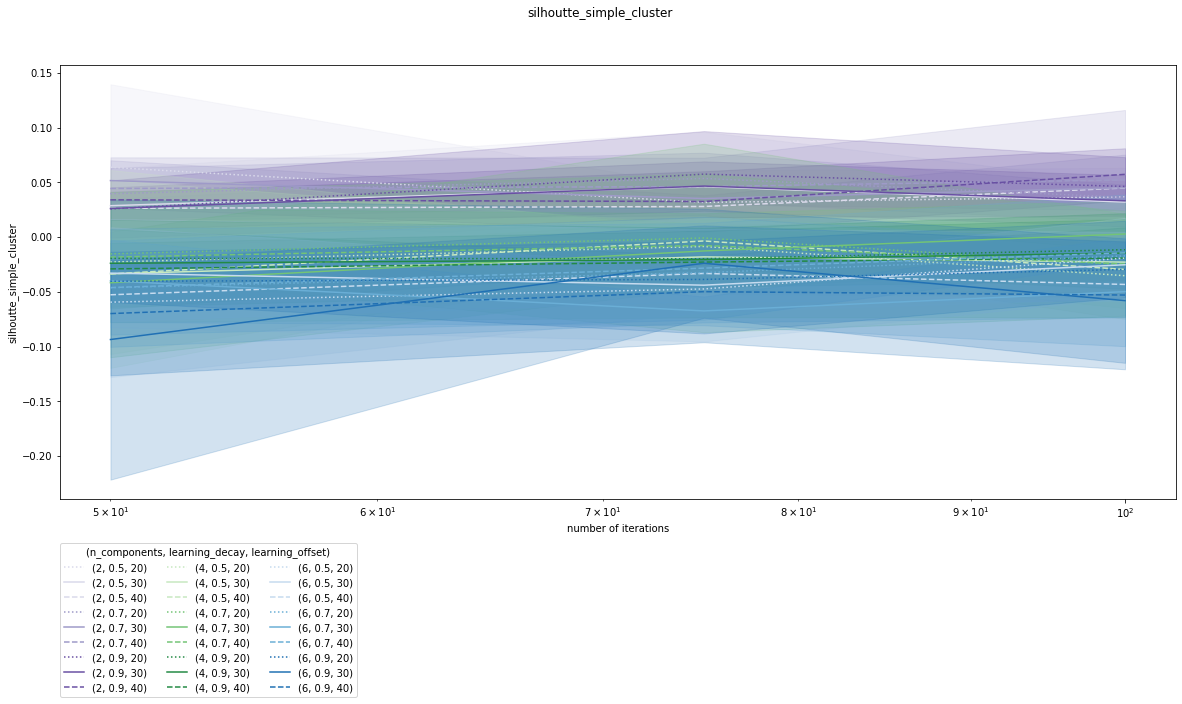

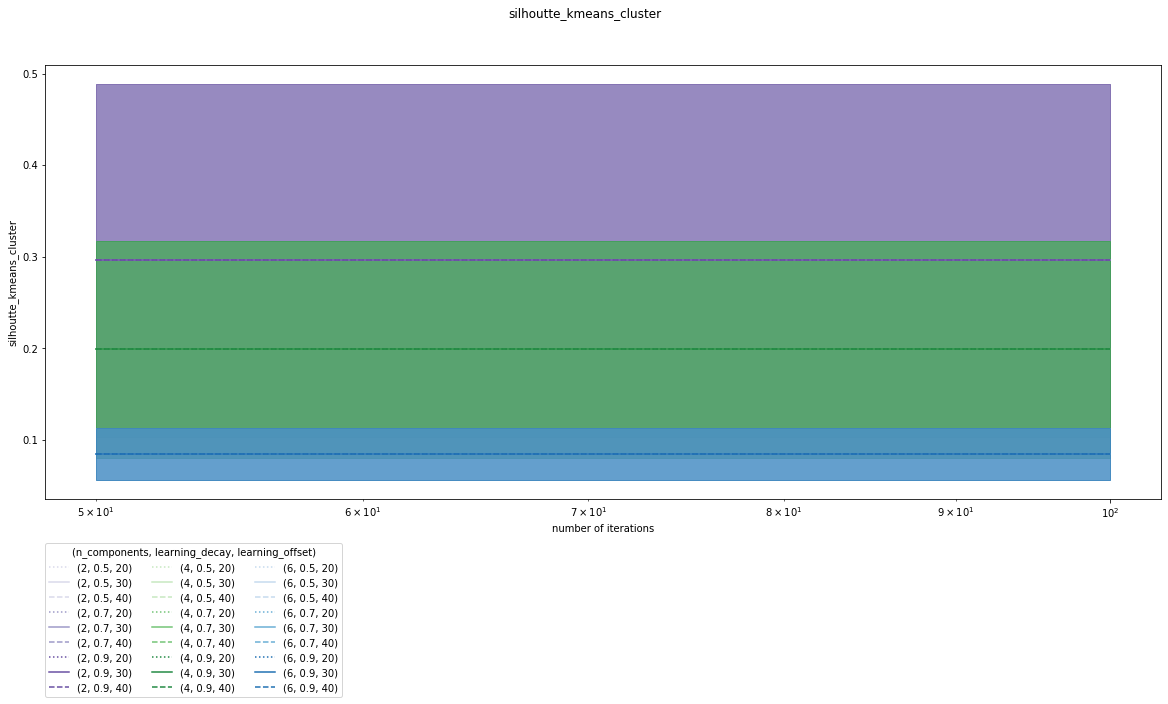

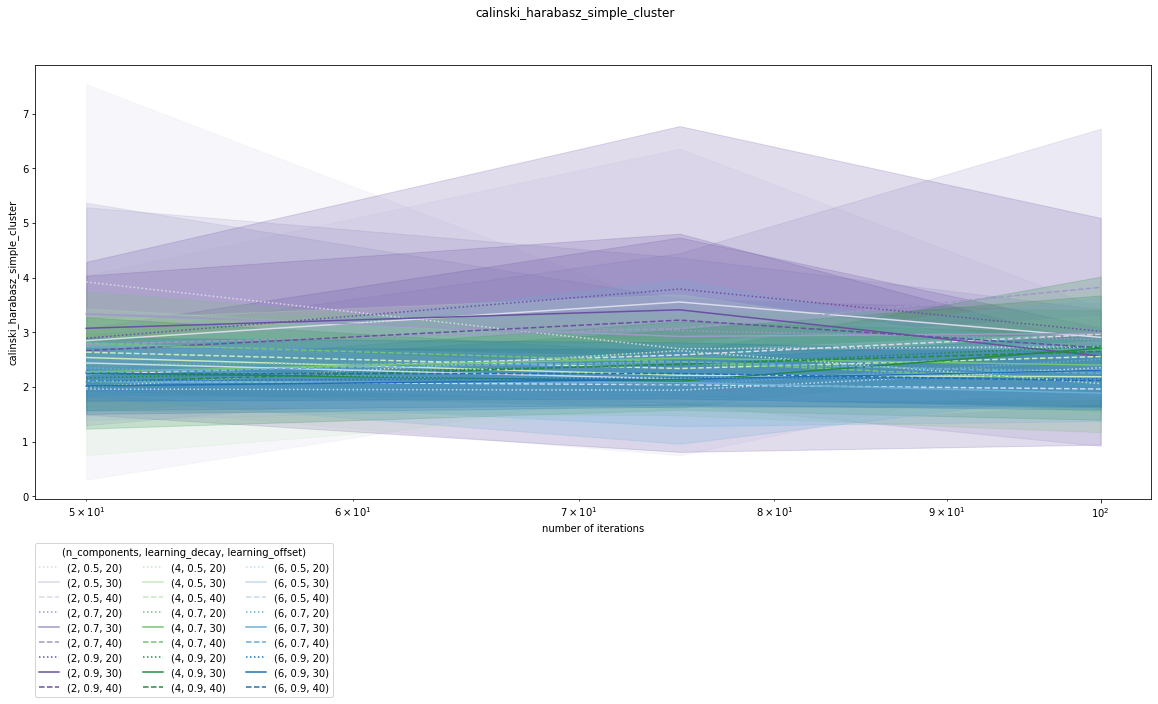

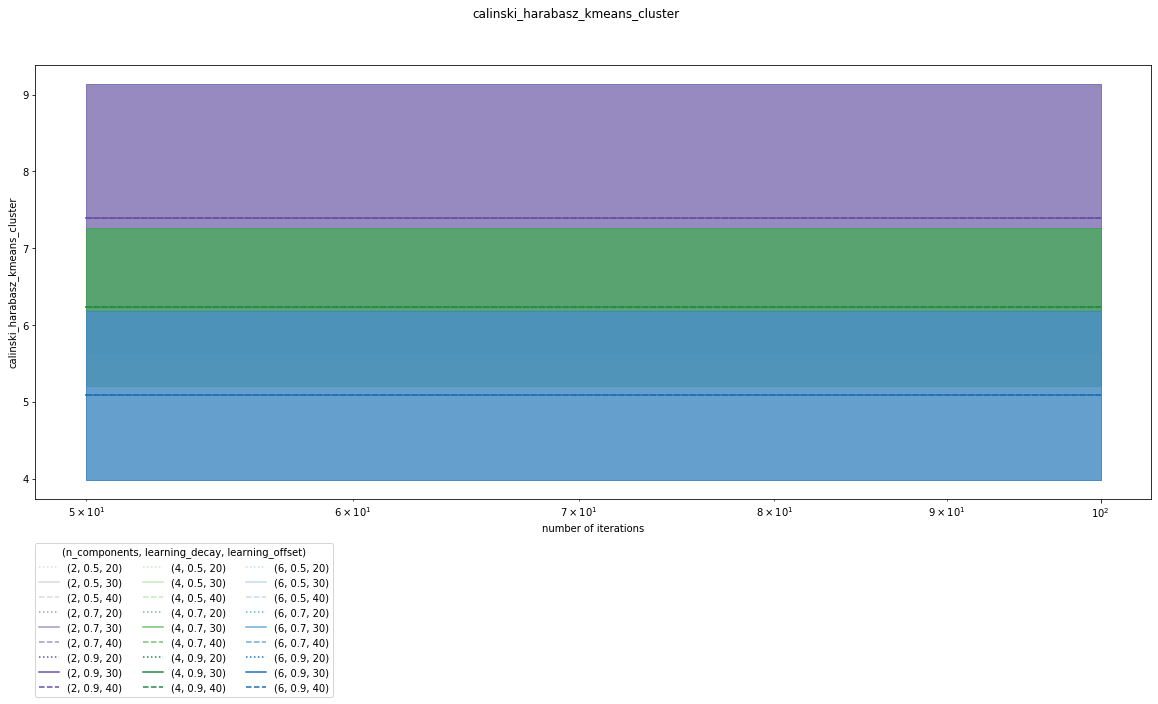

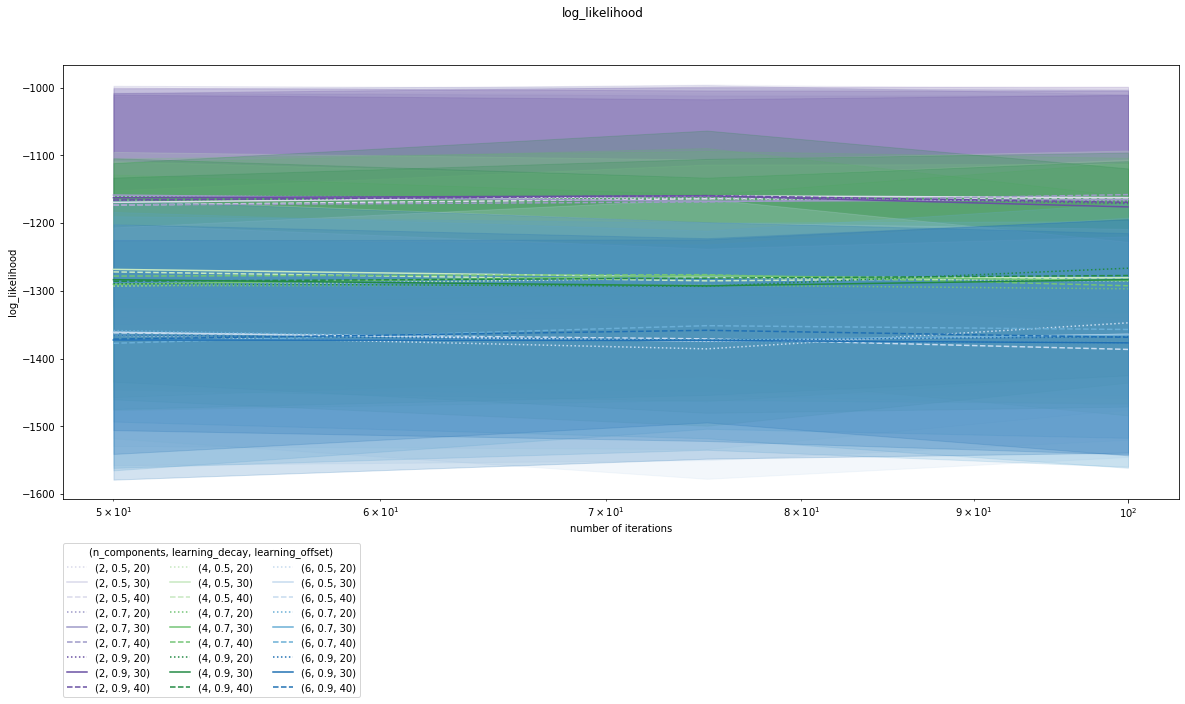

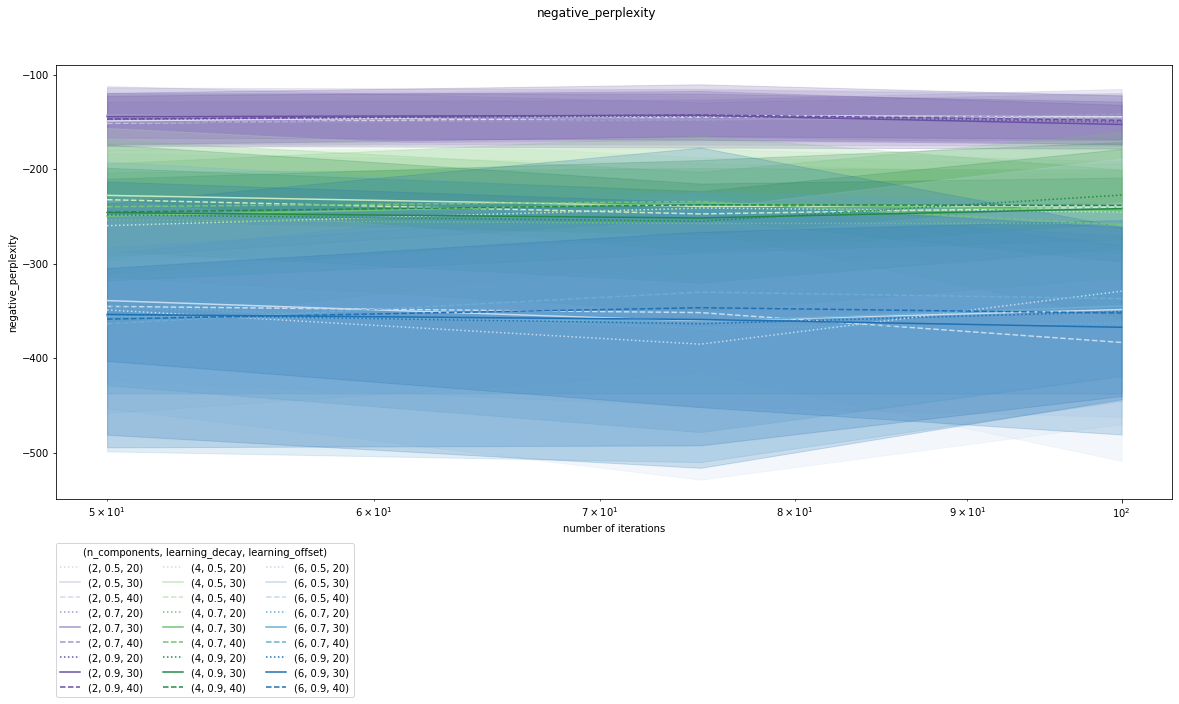

In [58]:
for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {2: 'Purples', 4: 'Greens', 6: 'Blues'}
    learning_decay_map = {0.5: 0.25, 0.7: 0.5, 0.9:0.75}
    learning_offset_map = {20:':', 30:'-', 40:'--'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for learning_decay, intensity_group in color_group.groupby('learning_decay'):
            color = cmap(learning_decay_map[learning_decay])
            for learning_offset, linestyle_group in intensity_group.groupby('learning_offset'):
                linestyle = learning_offset_map[learning_offset]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, learning_decay, learning_offset)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)

In [67]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           #'log_likelihood': custom_scorer_log_likelihood,
           #'negative_perplexity': custom_scorer_negative_perplexity
          }

param_grid={'n_components': [2, 4, 6], 
                                    'alpha': [0.5, .1, .2, .4],
                                    'l1_ratio': [0.25,0.5,0.75], 
                                    'max_iter': [50, 75, 100]}

# By default, scoring will be the LDA "score" method, which is log-likelihood
model_nmf = GridSearchCV(NMF(beta_loss='kullback-leibler', solver='mu'),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'silhoutte_kmeans_cluster',
                        cv=3, n_jobs = -1, verbose = 2)
model_nmf.fit(tfidf_weights)
results = model_nmf.cv_results_

pickle.dump(model_lda, open('gridsearchcv_nmf_customScoring_author_profession.pkl', 'wb'))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    5.9s finished
/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [68]:
print("\nProfessions in NMF model:")
print_top_words(model_nmf.best_estimator_, word_bag_cv.get_feature_names())


Professions in NMF model:
 Topic #0: professor university fellow psychology biology nd department human college research
 Topic #1: author english born speaker fiction popular british editor internet poet
 Topic #2: writer british journalist award winning historian nature story broadcaster physicist
 Topic #3: new book science time york national magazine appeared editor award
 Topic #4: american television actor prize award canadian nobel personality activist singer
 Topic #5: lso work history world woman known life social natural record



In [70]:
results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_nmf.cv_results_['param_'+param].data, columns = [param]))
#results

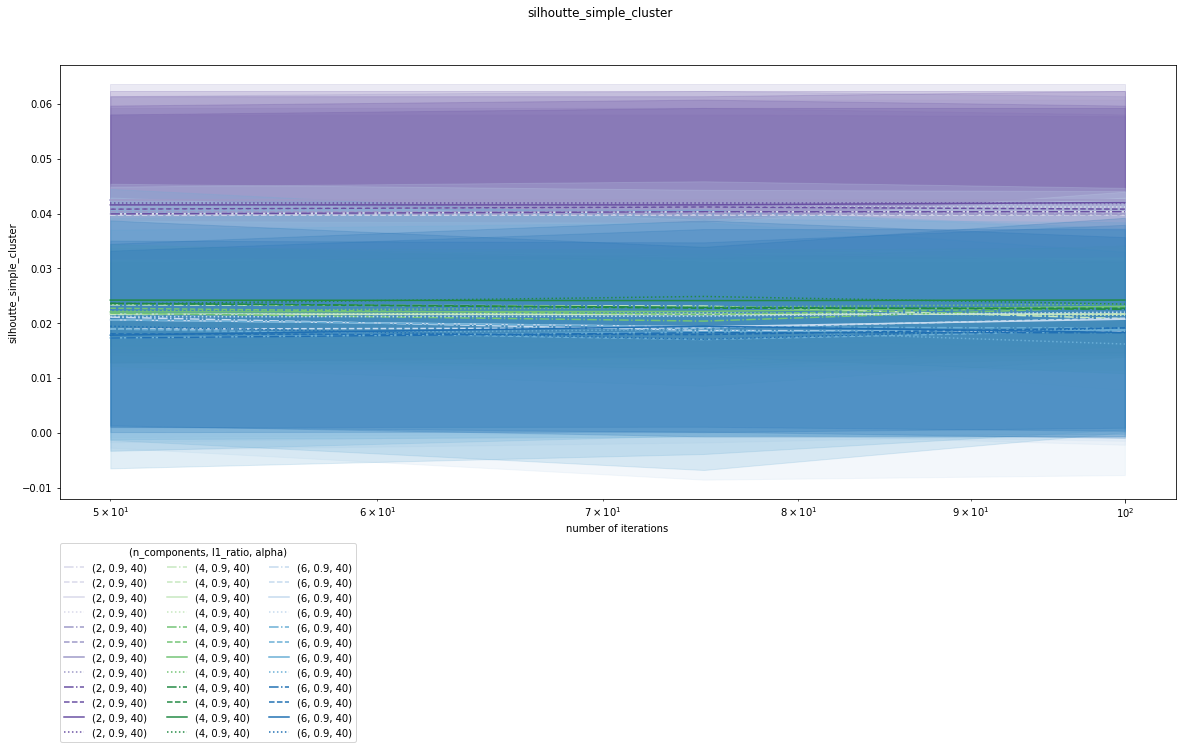

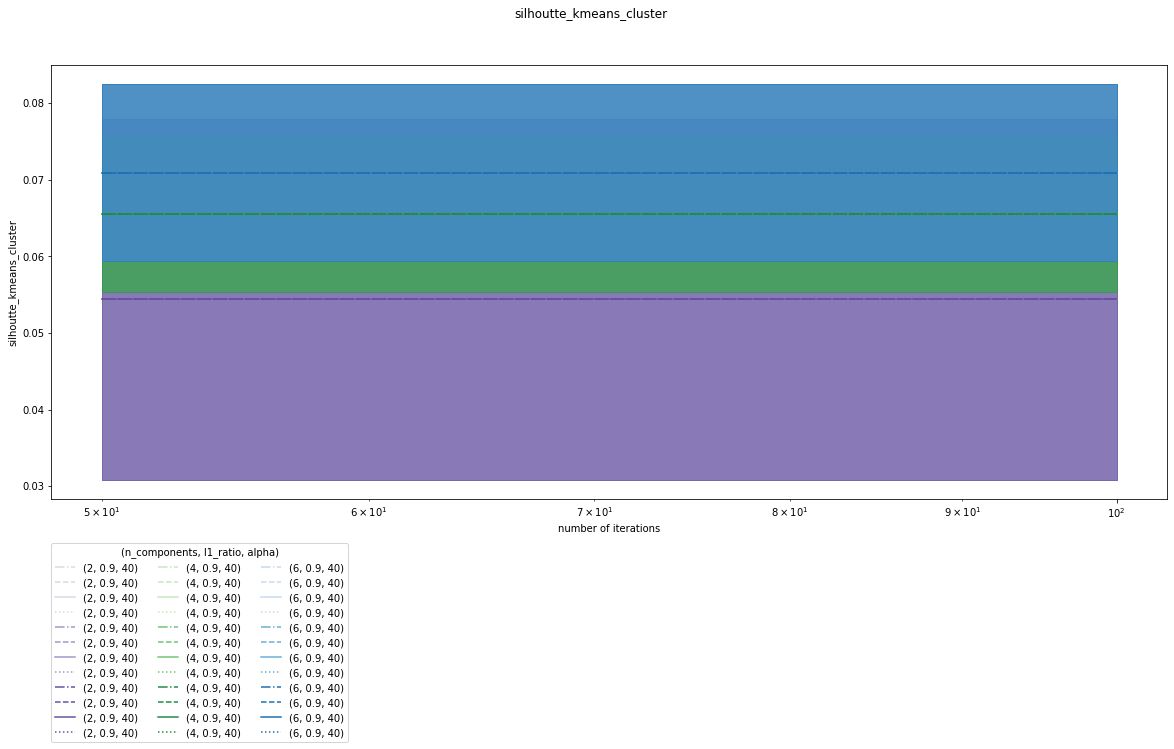

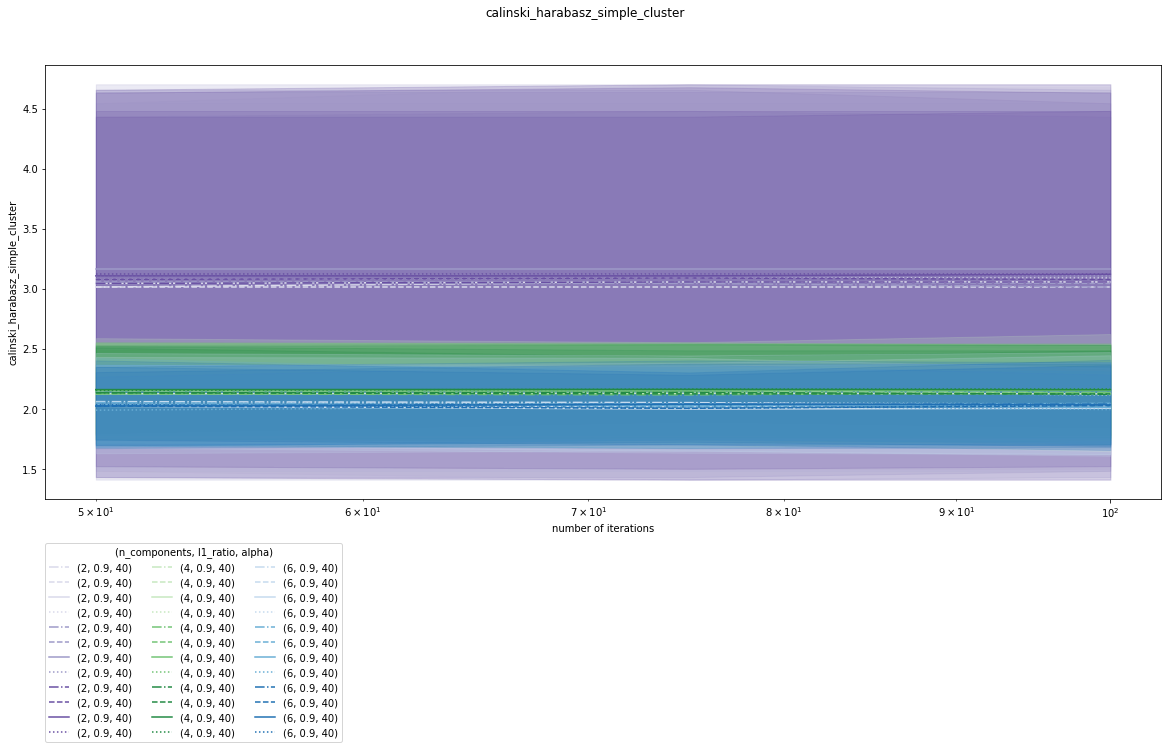

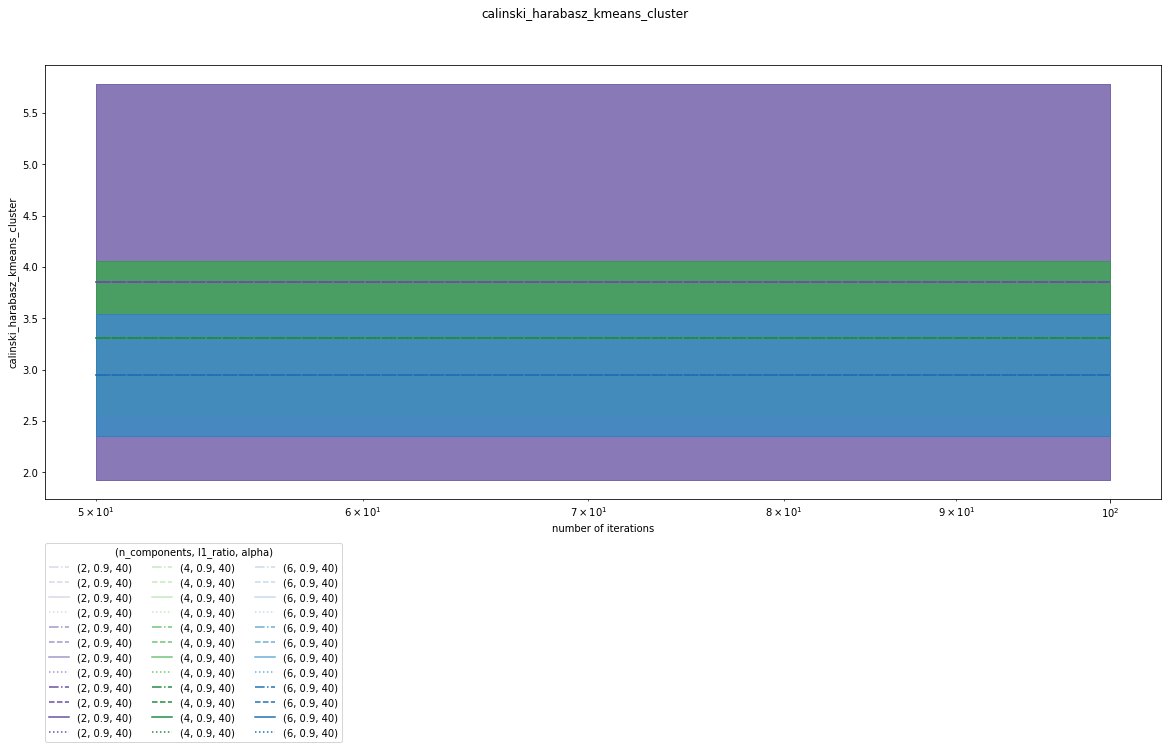

In [71]:
for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {2: 'Purples', 4: 'Greens', 6: 'Blues'}
    l1_ratio_map = {0.25: 0.25, 0.5: 0.5, 0.75:0.75}
    alpha_map = {0.5:':', 0.1:'-.', 0.2:'--',0.4:'-'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for l1_ratio, intensity_group in color_group.groupby('l1_ratio'):
            color = cmap(l1_ratio_map[l1_ratio])
            for alpha, linestyle_group in intensity_group.groupby('alpha'):
                linestyle = alpha_map[alpha]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, l1_ratio, alpha)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)